# Load candidates

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
CACHE = '/home/anhphantq/vdb/cache_train'
import os

import pickle
from tqdm import tqdm
import numpy as np
train_data = np.empty((100000000, 87), dtype = np.float64)
# train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = min(metadata['num_frags'], 100)
max_session = metadata['max_session']

offset = 0
for i in tqdm(range(num_frags)):
    with open(CACHE + f'/train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      num_cands.extend(data[1])
      for d in data[0]:
        train_data[offset: d.shape[0] + offset] = d 
         
        offset += d.shape[0]






100%|██████████| 64/64 [00:14<00:00,  4.55it/s]


In [3]:
train_data = train_data[:offset]

In [4]:
import numpy as np
# train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((26325051, 87), (8775017,))

In [5]:
from xgb_utils import *

In [6]:
import pandas as pd 

candidates = create_data(train_data, infer = False)


In [7]:
import pandas as pd
pd.set_option('display.max_columns', candidates.shape[1])

In [8]:
print(candidates.head())


         user        item  type  cofitness_cosub  cofitness_time_decay  \
0  11196819.0  13475750.0   0.0       278.058398            258.666690   
1  11196819.0  13133394.0   0.0       277.661152            241.457470   
2  11196819.0  13655447.0   0.0       159.431437            136.497863   
3  11196819.0  13768601.0   0.0       117.510003             95.521123   
4  11196819.0  13305598.0   0.0        63.002552             55.900837   

   num_appearance  num_cosub  coclick  cocart  coorder  num_clicks  num_carts  \
0           104.0      425.0    580.0     5.0      0.0      3225.0       66.0   
1            93.0      335.0    495.0     0.0      0.0      1841.0      177.0   
2            69.0      260.0    405.0     0.0      0.0      3861.0      211.0   
3            65.0      200.0    355.0     0.0      0.0      5321.0       41.0   
4            26.0       90.0    140.0     0.0      0.0      1913.0       21.0   

   num_orders  item_degree   item_pr  recent_num_clicks  recent_num_

# Train params

In [9]:
from xgb_utils import *


PARAMS = {
    'max_depth' : 6,
    'eta': 0.3,
    'min_child_weight': 1000,
    'num_parallel_tree': 1,
    'tree_method': 'hist',
    'max_bin': 256,
    'objective':'rank:pairwise',   
}
N_SPLITS = 3
NUM_TREE = 1000
MODEL_PATH = '/home/anhphantq/xgboost'
VERSION = '13'

# Train for each type

In [10]:
from xgb_utils import get_len_group

In [11]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1
tar['item'] = tar['item'] + max_session

In [12]:
tar

,user,type,item,label
113400,11188590,0,13507107,1
113401,11188591,0,13456936,1
113402,11188591,1,14497099,1
113402,11188591,1,14136334,1
113402,11188591,1,13870063,1
...,...,...,...,...
225106,11278648,2,12935400,1
225107,11278649,0,12903873,1
225108,11278650,0,12946146,1
225109,11278651,0,13785225,1


In [13]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
import matplotlib.pyplot as plt
def train(tar_, candidates_, num_cands_, t, id_type):
  
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove old version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  idx = candidates_['type'] == id_type
  candidates = candidates_[idx].copy()
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)
  
  
  del candidates['type'], candidates['user_type']
  
 

  skf = GroupKFold(n_splits=N_SPLITS)
  fig, axs = plt.subplots(1,3, figsize = (30, 10))
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -4]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -4]
      y_valid = candidates.iloc[valid_idx, -1]

      # weight = np.where(y_train.values > 0, 5, 1)
      # weight1 = np.where(y_valid.values > 0, 5, 1)

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count()) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count()) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = { 'nthread' : os.cpu_count()
      , **PARAMS}

      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          early_stopping_rounds= 30,    
          verbose_eval=5)
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model, ax = axs[fold], max_num_features= 50)

[0]	train-map:0.75381	valid-map:0.75449
[5]	train-map:0.75624	valid-map:0.75637
[10]	train-map:0.75733	valid-map:0.75669
[15]	train-map:0.75827	valid-map:0.75751
[20]	train-map:0.75926	valid-map:0.75795
[25]	train-map:0.76004	valid-map:0.75833
[30]	train-map:0.76063	valid-map:0.75850
[35]	train-map:0.76120	valid-map:0.75851
[40]	train-map:0.76183	valid-map:0.75854
[45]	train-map:0.76230	valid-map:0.75880
[50]	train-map:0.76249	valid-map:0.75875
[55]	train-map:0.76269	valid-map:0.75874
[60]	train-map:0.76304	valid-map:0.75880
[65]	train-map:0.76337	valid-map:0.75885
[70]	train-map:0.76355	valid-map:0.75909
[75]	train-map:0.76379	valid-map:0.75903
[80]	train-map:0.76428	valid-map:0.75903
[85]	train-map:0.76449	valid-map:0.75901
[90]	train-map:0.76490	valid-map:0.75904
[95]	train-map:0.76531	valid-map:0.75913
[100]	train-map:0.76550	valid-map:0.75925
[105]	train-map:0.76576	valid-map:0.75884
[110]	train-map:0.76606	valid-map:0.75873
[115]	train-map:0.76641	valid-map:0.75875
[120]	train-ma

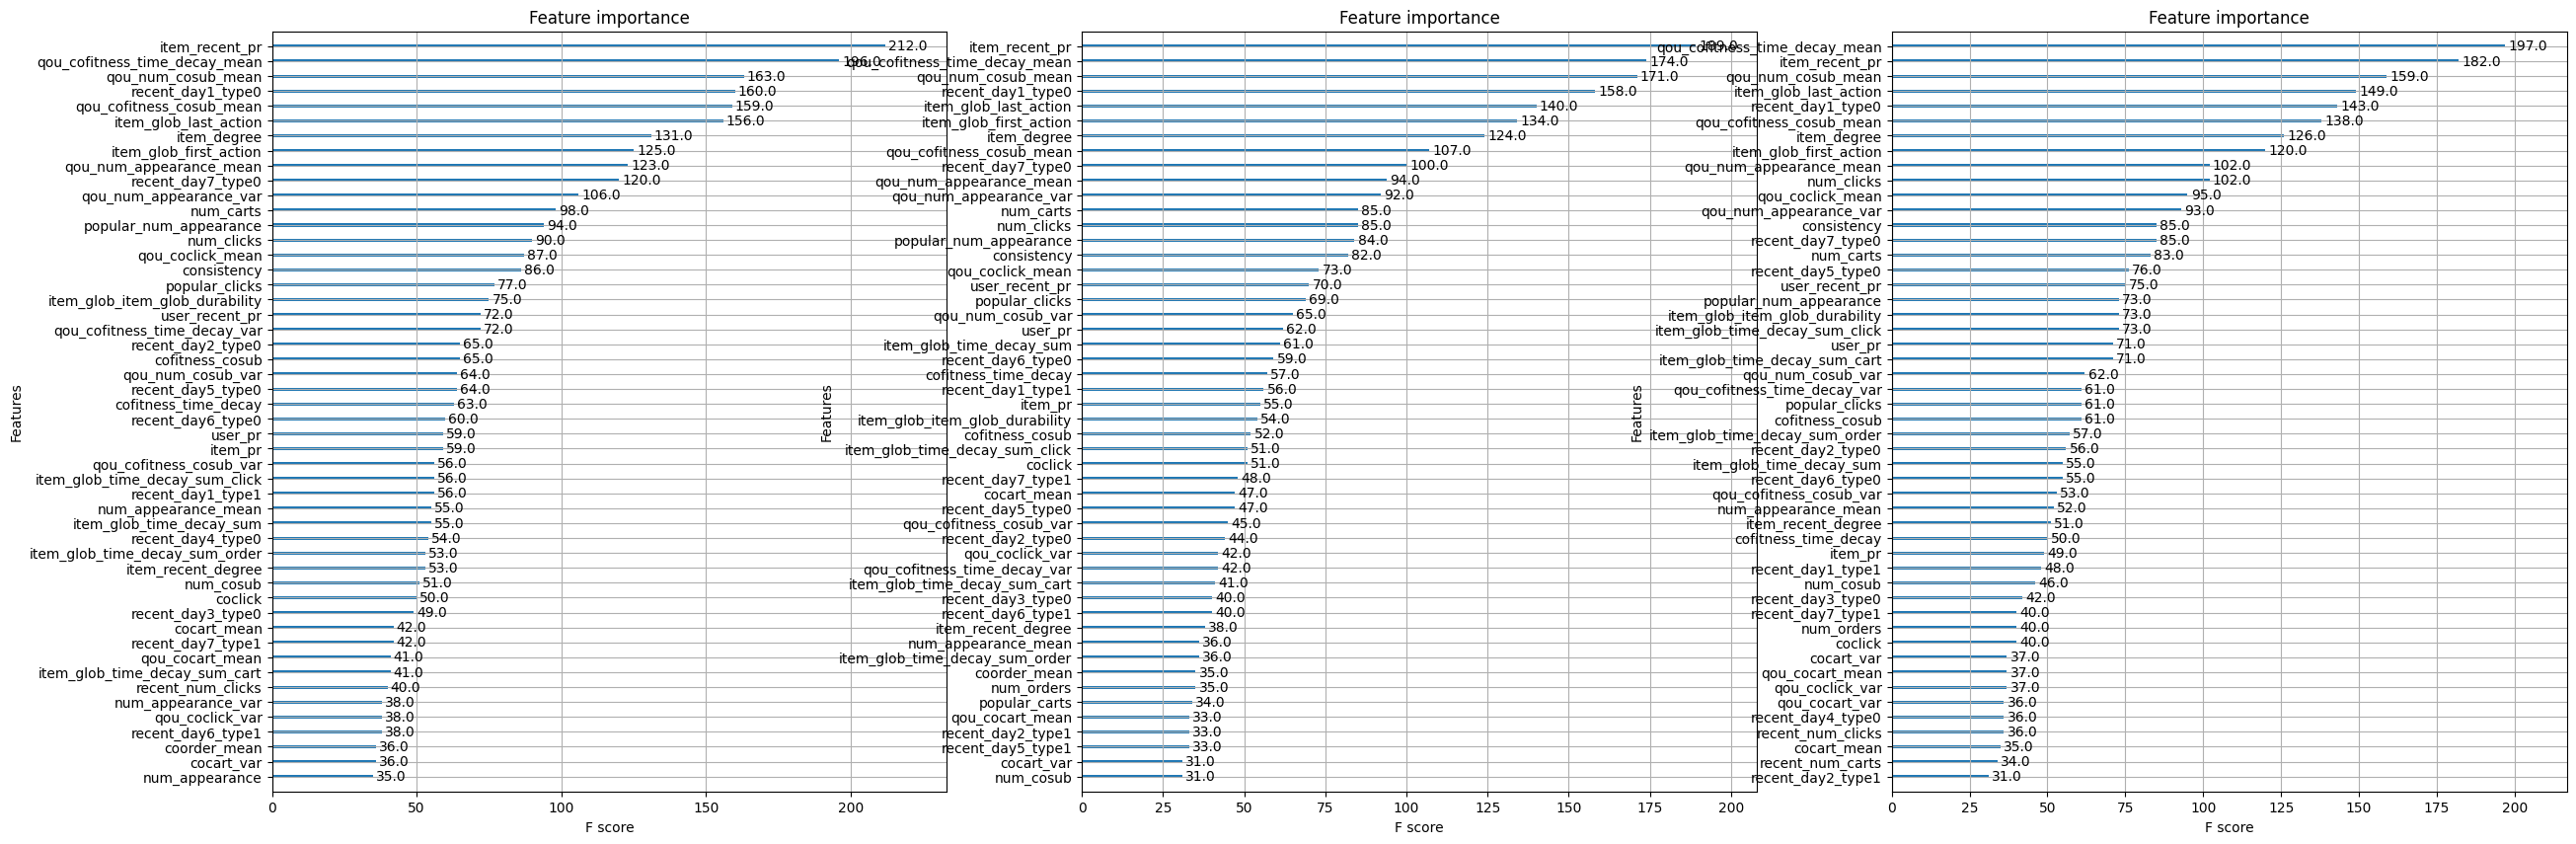

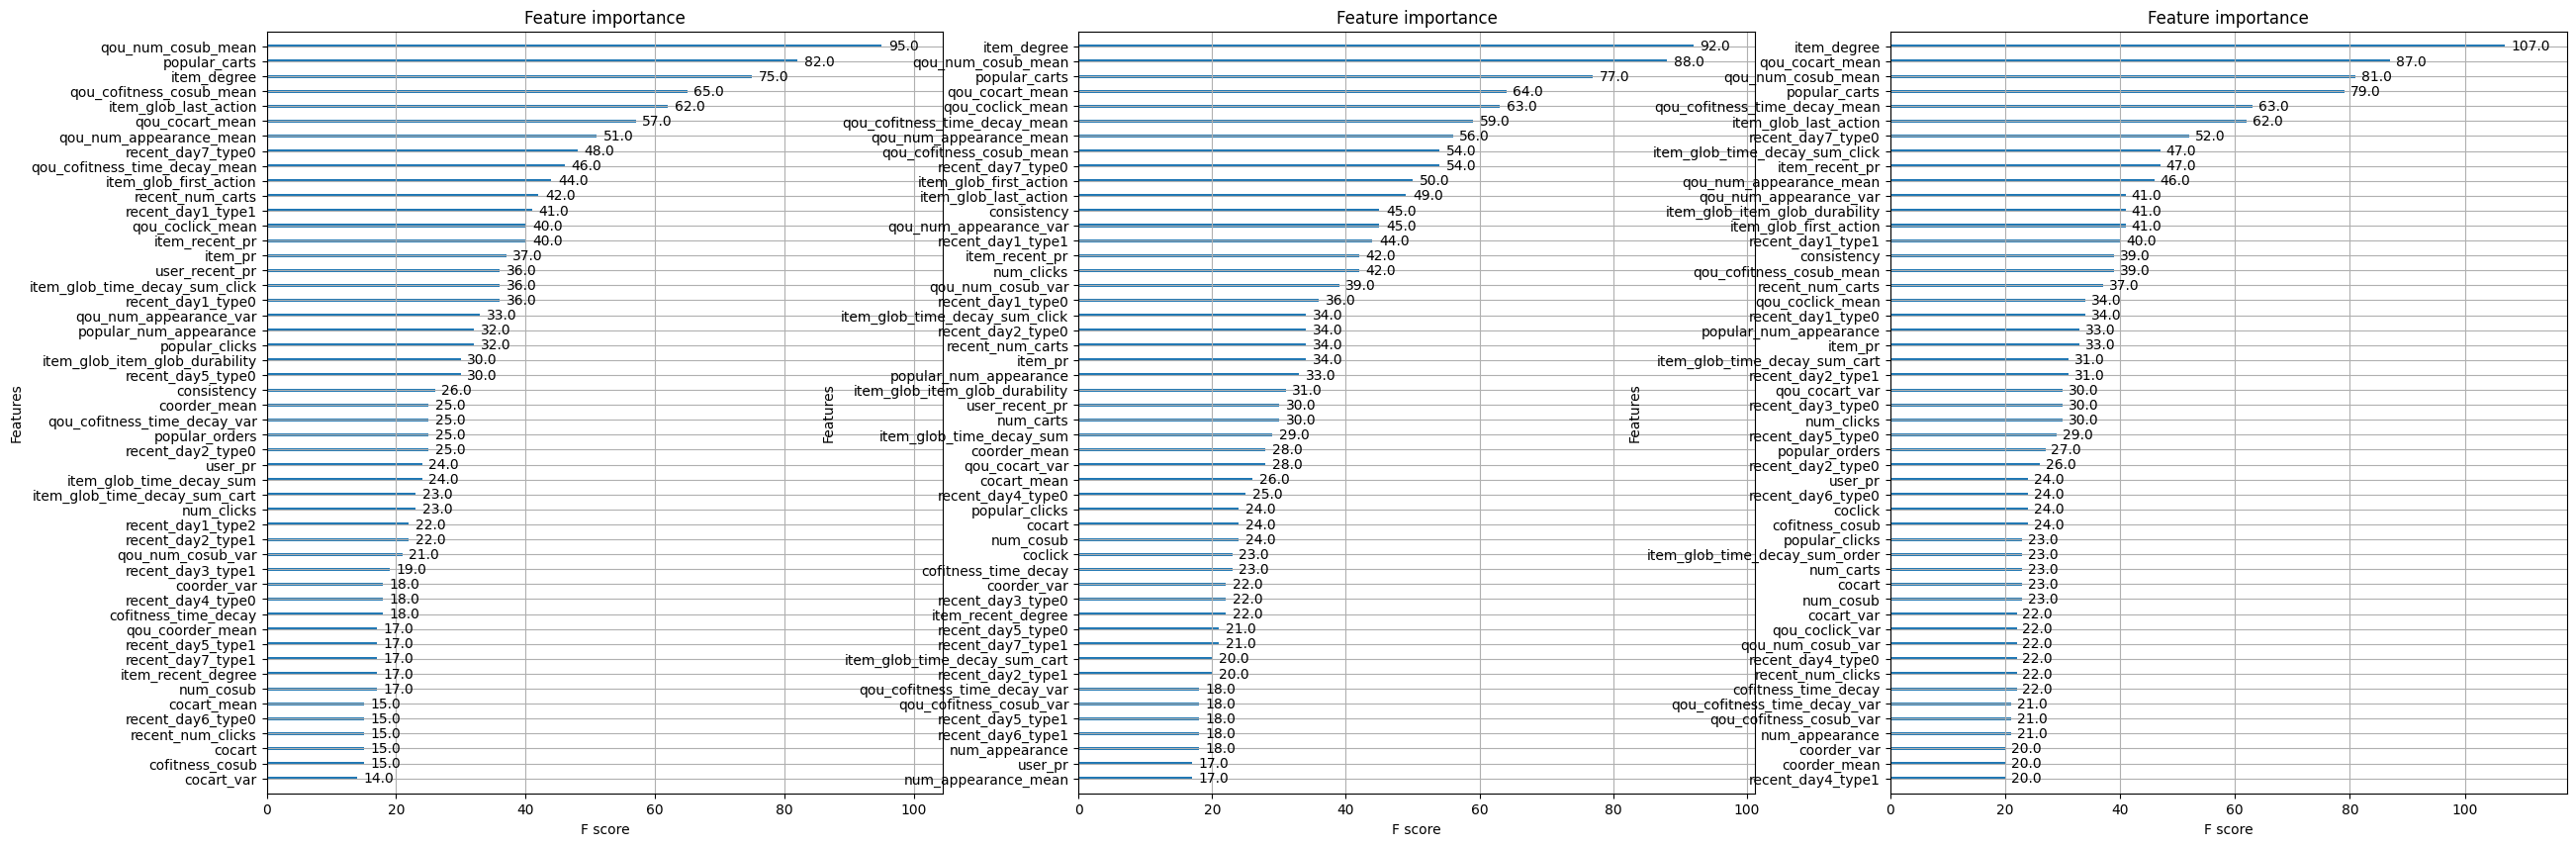

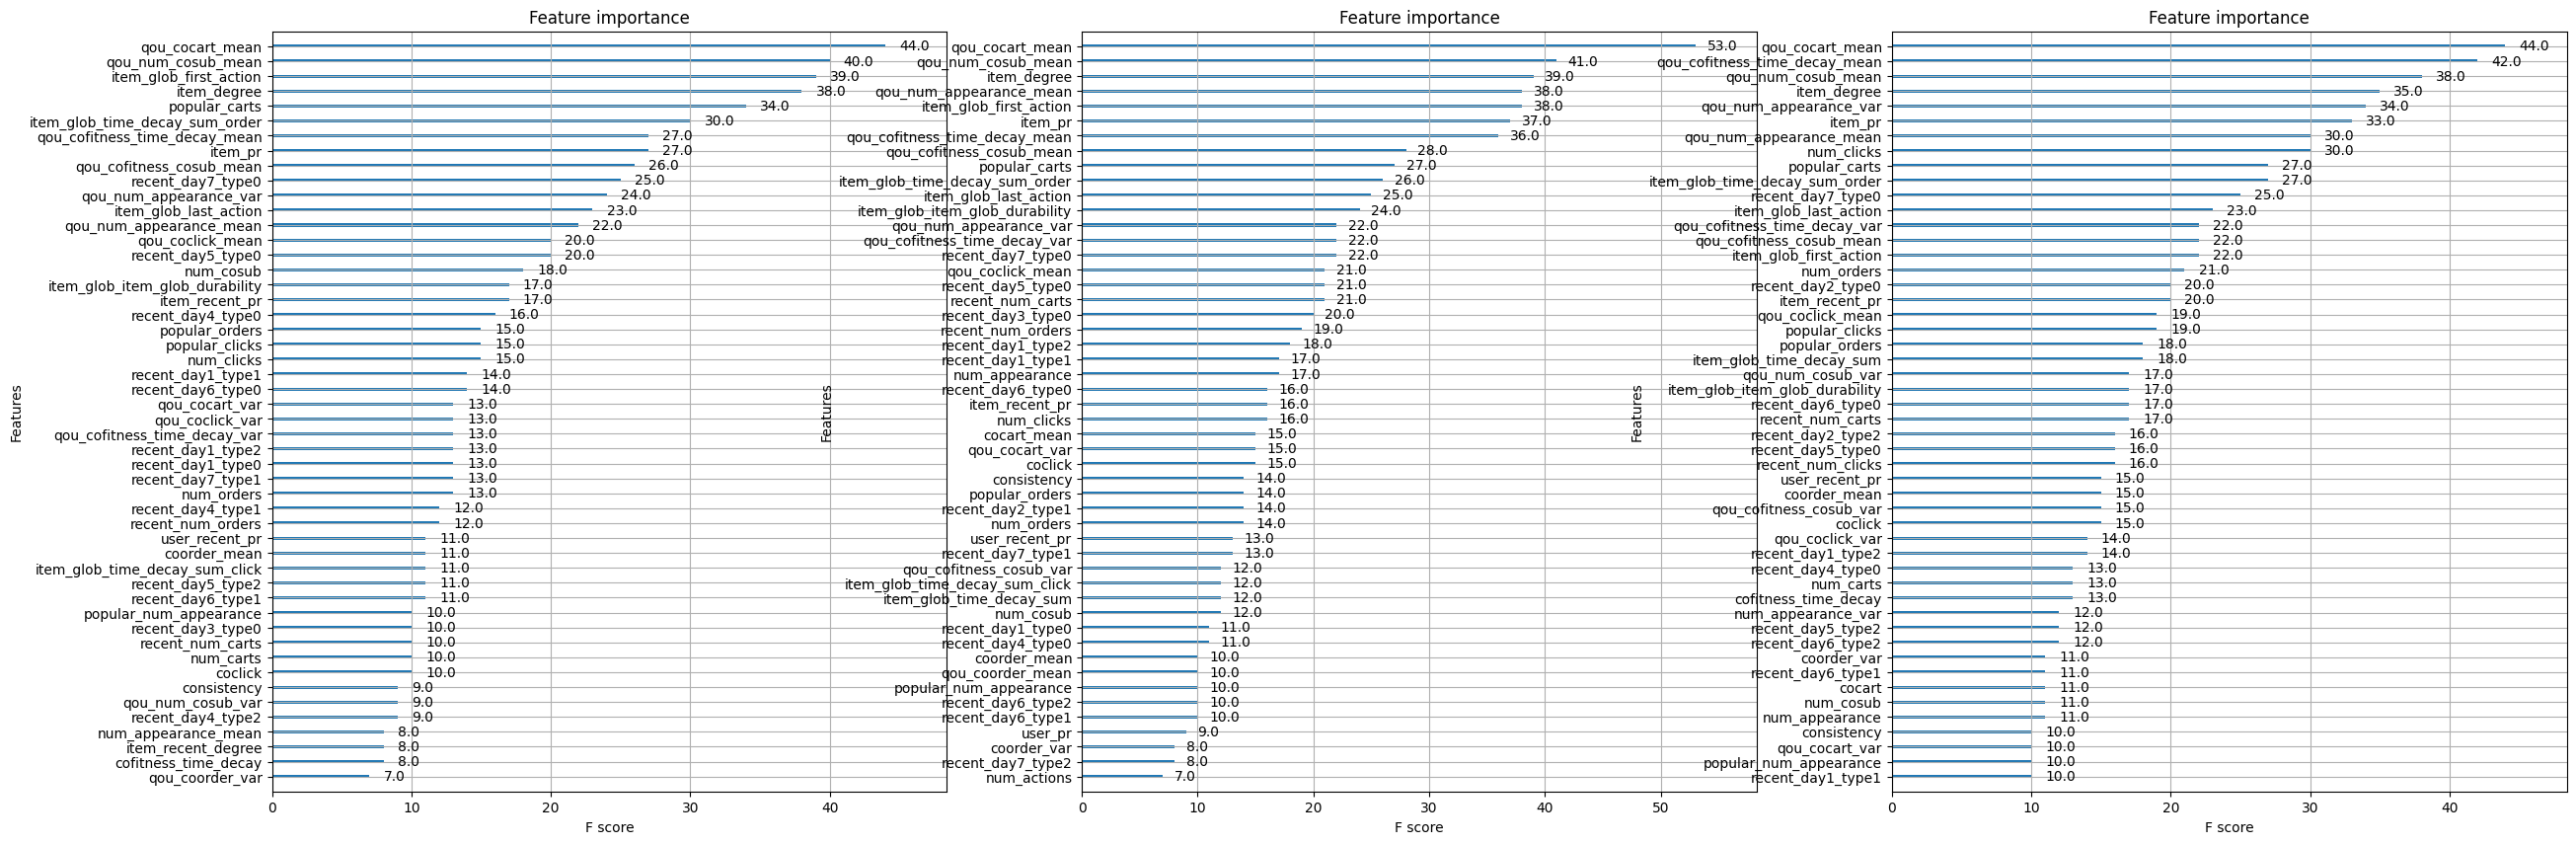

In [14]:
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, num_cands, t, id_type)